<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/CapstoneProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Using GPU

In [0]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.5 GB  | Proc size: 503.2 MB
GPU RAM Free: 14968MB | Used: 111MB | Util   1% | Total 15079MB


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls

drive  sample_data


# 2. Downloading the dataset 

In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/'

chest_xray  __MACOSX  test  train  val


In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

test  train  val


In [0]:
import matplotlib.pyplot as plt
import os
import pandas as pd

In [0]:
# assigning variables with the proper file path for the training, validation and test set
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [0]:
# assigning variables with the proper file path for the normal and pneumonia images 
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
val_normal_dir = os.path.join(val_dir, 'NORMAL') 
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA') 
test_normal_dir = os.path.join(test_dir, 'NORMAL')  
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA') 

In [0]:
# looking at how many images are in each directory
dir = [train_normal_dir, train_pneumonia_dir, val_normal_dir,
            val_pneumonia_dir, test_normal_dir, test_pneumonia_dir]
dir_name = ['train_normal_dir', 'train_pneumonia_dir', 'val_normal_dir',
            'val_pneumonia_dir', 'test_normal_dir', 'test_pneumonia_dir']
for name, dir in zip(dir_name, dir):
  num_of_images = len(os.listdir(dir))
  print ('Number of images in {}: {}'.format(name, num_of_images))

Number of images in train_normal_dir: 1354
Number of images in train_pneumonia_dir: 3875
Number of images in val_normal_dir: 8
Number of images in val_pneumonia_dir: 8
Number of images in test_normal_dir: 234
Number of images in test_pneumonia_dir: 390


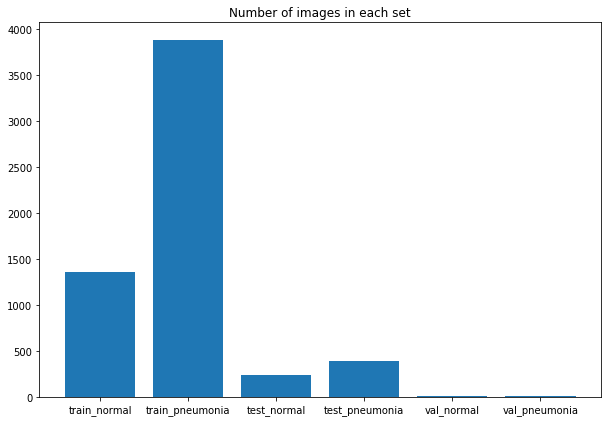

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.3,1.3])
dir_name_ = [train_normal_dir, train_pneumonia_dir, test_normal_dir,
             test_pneumonia_dir,val_normal_dir, val_pneumonia_dir, ]
size = []
for dir in dir_name_:
  l = len(os.listdir(dir))
  size.append(l)
ax.bar(dir_name_,size)
labels = ['train_normal', 'train_pneumonia', 'test_normal', 
          'test_pneumonia','val_normal', 'val_pneumonia',]
ax.set_title('Number of images in each set')
ax.set_xticklabels(labels)
plt.show()

Text(0.5, 1.0, 'Test set, Condition: Pneumonia')

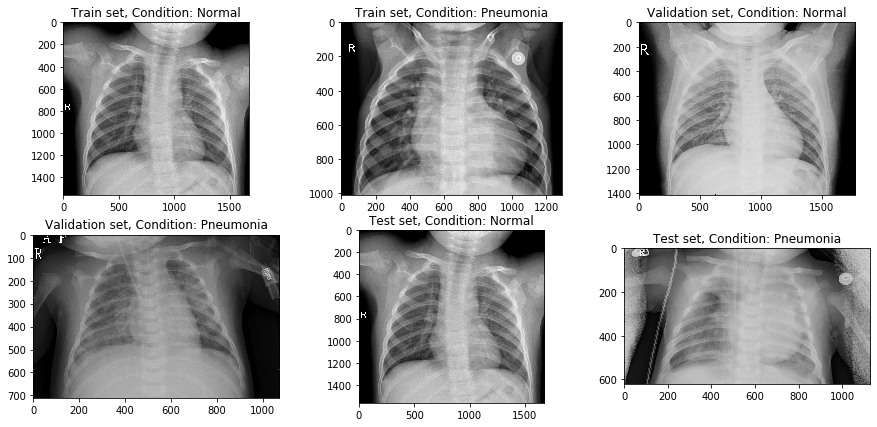

In [0]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
#plt.tight_layout()

ax[0].imshow(plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])), cmap='gray')
ax[0].set_title('Train set, Condition: Normal')
ax[1].imshow(plt.imread(os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[0])), cmap='gray')
ax[1].set_title('Train set, Condition: Pneumonia')
ax[2].imshow(plt.imread(os.path.join(val_normal_dir, os.listdir(val_normal_dir)[0])), cmap='gray')
ax[2].set_title('Validation set, Condition: Normal')
ax[3].imshow(plt.imread(os.path.join(val_pneumonia_dir, os.listdir(val_pneumonia_dir)[0])), cmap='gray')
ax[3].set_title('Validation set, Condition: Pneumonia')
ax[4].imshow(plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])), cmap='gray')
ax[4].set_title('Test set, Condition: Normal')
ax[5].imshow(plt.imread(os.path.join(test_pneumonia_dir, os.listdir(test_pneumonia_dir)[0])), cmap='gray')
ax[5].set_title('Test set, Condition: Pneumonia')


# Data Preperation
ImageDataGenerator class provided by tf.keras can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
train_image_generator = ImageDataGenerator(rescale=1./255,  
                                           horizontal_flip=True) # Generator for training data
val_image_generator = ImageDataGenerator(rescale=1./255) # Generator for validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for test data

After defining the generators for training and validation images, the flow_from_directory method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [0]:
batch_size = 32
epochs = 15
img_height = 150
img_width = 150

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary',
                                                           shuffle=True)
val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',
                                                             )
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',
                                                              shuffle=True)

Found 5229 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
print("Shape of training images {}".format(train_data_gen.image_shape))
print("Shape of test images {}".format(test_data_gen.image_shape))
print("Shape of validation images {}".format(val_data_gen.image_shape))

Shape of training images (150, 150, 3)
Shape of test images (150, 150, 3)
Shape of validation images (150, 150, 3)


# Create the model

In [0]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

In [0]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(img_height, img_width ,3)))
#model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
#model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
#model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
#model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation='sigmoid'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Compile Model

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [0]:
total_train = len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir))
total_test = len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir))
print(total_train, total_test)

5229 624


In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, mode='min')

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size, 
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size,
    callbacks=[early_stopping, lr_reduce])

Epoch 1/15
163/163 [==============================] - 71s 436ms/step - loss: 1.0533 - acc: 0.7783 - val_loss: 9.2695 - val_acc: 0.6250
Epoch 2/15
163/163 [==============================] - 69s 424ms/step - loss: 0.3799 - acc: 0.8645 - val_loss: 10.0128 - val_acc: 0.6250
Epoch 3/15
163/163 [==============================] - 70s 427ms/step - loss: 0.2376 - acc: 0.9109 - val_loss: 6.8618 - val_acc: 0.6250
Epoch 4/15
 19/163 [==>...........................] - ETA: 52s - loss: 0.9323 - acc: 0.6513
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 69s 425ms/step - loss: 0.1945 - acc: 0.9253 - val_loss: 0.9323 - val_acc: 0.6513
Epoch 5/15
163/163 [==============================] - 67s 410ms/step - loss: 0.1343 - acc: 0.9504 - val_loss: 2.3316 - val_acc: 0.6859
Epoch 6/15
 19/163 [==>...........................] - ETA: 51s - loss: 0.3568 - acc: 0.8635
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477

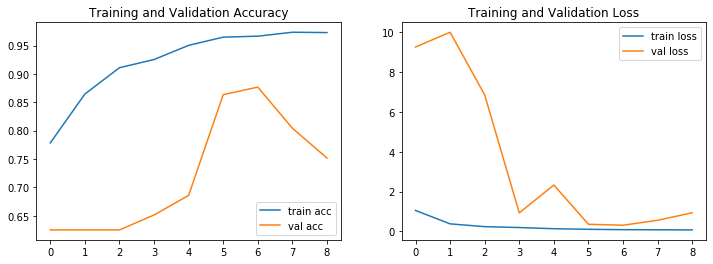

In [0]:
# Plot model accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate_generator(val_data_gen, steps=16)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.8125
Test loss: 0.3231253456324339
